# IDOVEN Challenge Notebook - Jaime Cortón González

## Index

* Libraries import
* Data Loading 
* Data Visualization
* Model application
* Summary/Conclusions

## Import libraries, ownership declaration and contact info

In [46]:
__author__="Jaime Cortón González"
__email__ ="corton35jaime@gmail.com"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import wfdb
from wfdb import processing
from scipy.signal import find_peaks

from utils import load_raw_data

In [ ]:
!wget https://github.com/jaimecorton/DEMO_GITHUB/blob/master/utils.py
from utils import *

In [32]:
!unzip -qn dataset.zip

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.2/

In [50]:
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

In [79]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
val_fold  = 9

# Train
X_train = X[np.where( (Y.strat_fold != test_fold) | (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) | (Y.strat_fold != test_fold)].diagnostic_superclass
# Val
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[(Y.strat_fold == val_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

Shape of training set (patients, sessions, leads) = (21801, 1000, 12)
Shape of training set (patients,) = (19603,)

Shape of validation set (patients, sessions, leads) = (2183, 1000, 12)
Shape of validation set (patients,) = (2183,)

Shape of test set (patients, sessions, leads) = (2183, 1000, 12)
Shape of test set (patients,) = (2183,)
1000


Text(0, 0.5, 'Amplitude[mV]')

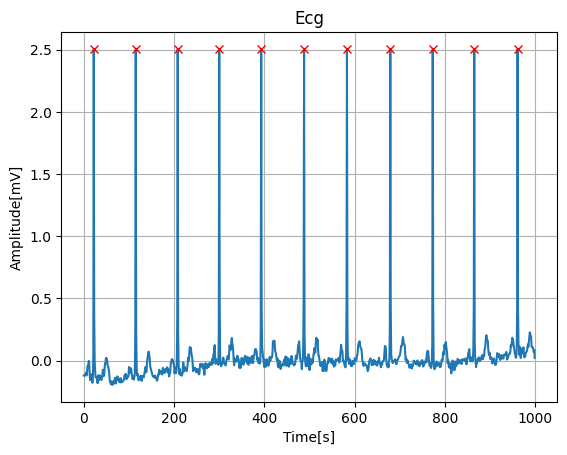

In [109]:
print(f'Shape of training set (patients, sessions, leads) = {np.shape(X_train)}')
print(f'Shape of training set (patients,) = {np.shape(y_train)}\n')
print(f'Shape of validation set (patients, sessions, leads) = {np.shape(X_val)}')
print(f'Shape of validation set (patients,) = {np.shape(y_val)}\n')
print(f'Shape of test set (patients, sessions, leads) = {np.shape(X_val)}')
print(f'Shape of test set (patients,) = {np.shape(y_val)}')

print(np.shape(X_train[0,:,0])[0])

signal = X_train[0,:,0]
max_time   = np.shape(signal)[0]/100
time_steps = np.linspace(0, max_time, np.shape(X_train[0,:,0])[0]) 

peaks, _ = find_peaks(signal, prominence=0.4)

plt.figure()
plt.plot(signal)
plt.plot(peaks, signal[peaks], "xr")
plt.title('Ecg')
#plt.xlim(0,100)
plt.tick_params(axis='x', which='major')

plt.xlabel('Time[s]')
plt.ylabel('Amplitude[mV]')

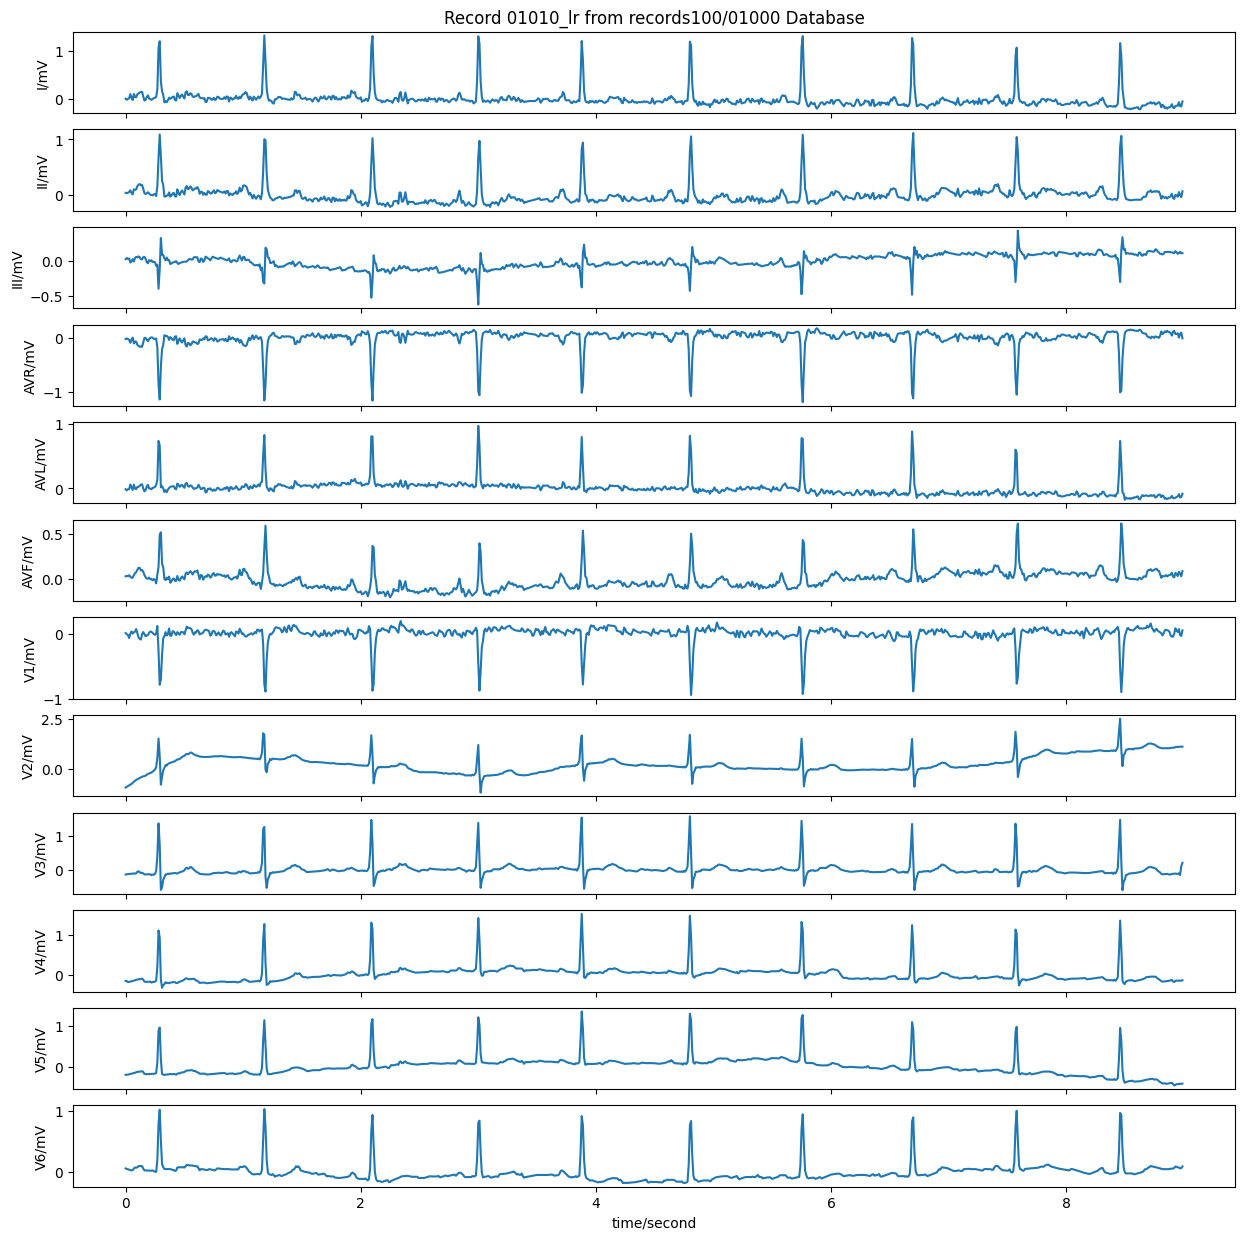

In [71]:
# Read a WFDB record. Plot all channels, and the annotation on top of channel 0.
folder = 1
sample = 10
record = wfdb.rdrecord(f'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', sampfrom = 100)

wfdb.plot_wfdb(record=record, 
               title=f'Record {folder:02d}{sample:03d}_lr from records100/{folder:02d}000 Database',
               time_units='seconds',
               figsize=(15, 15))

{'fs': 100, 'sig_len': 900, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': []}
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


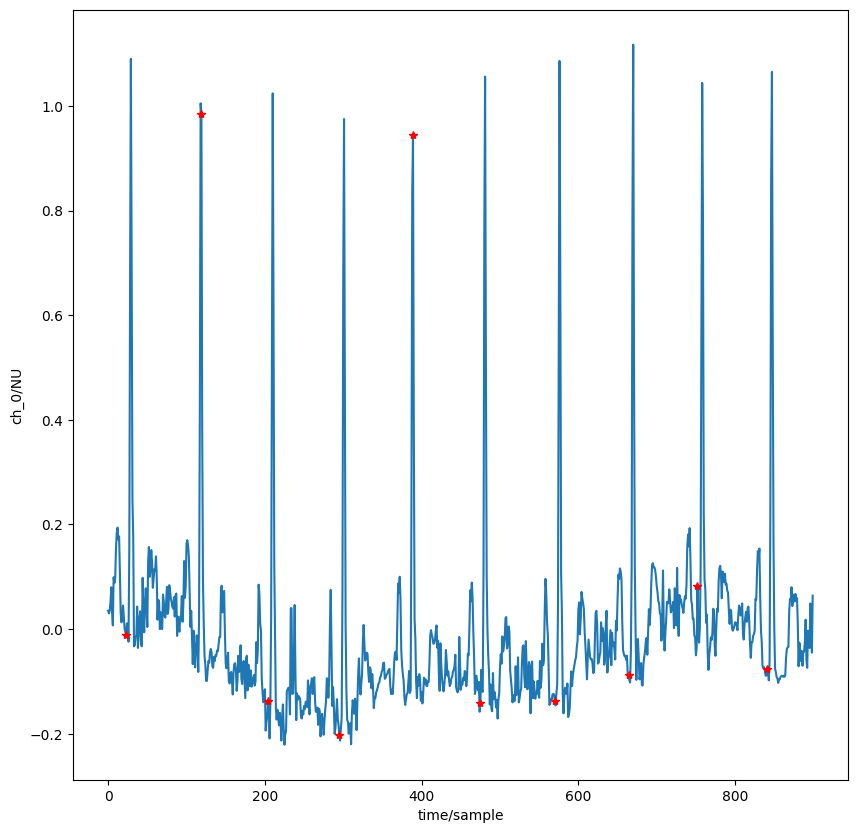

[nan nan nan nan nan nan nan nan nan nan]


In [105]:
lead = 1
sig, fields = wfdb.rdsamp(f'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', sampfrom = 100)
print(fields)
xqrs = processing.XQRS(sig=sig[:,lead], fs=fields['fs'])

xqrs.detect()

wfdb.plot_items(signal=sig[:,lead], ann_samp=[xqrs.qrs_inds], figsize=(10,10))
hb = processing.compute_hr(sig_len=10, qrs_inds=[xqrs.qrs_inds], fs=fields['fs'])
print(hb)